# Introduction

This goal of this project is to analyze biodiversity data from the National Parks Service, particularly around various species observed in different national park locations.

### Concepts convered
- **Project Scoping**: Determining project goals; formulating problem statements and research questions
- **Data Wrangling**: Handling null values; text replacement; string formatting; merging datasets
- **Exploratory Data Analysis**: Descriptive statistics
- **Data Visualisation**: Plotting nominal values using Matplotlib, Seaborn
- **Statistical Analysis of Nominal Variables**:
    - Chi-squared test using scipy
    - Multiple comparison/multitest correction - Familywise Error Rate (FWER) and False Discovery Rate (FDR) using  statsmodels

**Data sources:**

Both `Observations.csv` and `Species_info.csv` was provided by [Codecademy.com](https://www.codecademy.com).

Note: The data for this project is *inspired* by real data, but is mostly fictional.

## Scoping

### Project Goals

This project takes the perspective of a biodiversity analyst for the National Parks Service. The National Park Service wants to ensure the survival of at-risk species, to maintain the level of biodiversity within their parks. The main objectives as an analyst will be understanding characteristics about the species and their conservations status, and those species and their relationship to the national parks. Some questions that are posed:

- What is the distribution of conservation status for species?
- Are certain types of species more likely to be endangered?
- Are the differences between species and their conservation status significant?
- Which animal is most prevalent and what is their distribution amongst parks?

### Data

This project has two datasets that came with the package: The first `csv` file has information about each species and another has observations of species with park locations.

### Analysis

In this section, descriptive statistics and data visualization techniques will be employed to understand the data better. Statistical inference will also be used to test if the observed values are statistically significant. Some of the key metrics that will be computed include: 

1. Distributions
1. Counts
1. Relationship between species
1. Conservation status of species
1. Observations of species in parks. 

### Evaluation

The goals will be revisited to see if the output of the analysis corresponds to the questions first set to be answered (in the goals section). This section will also reflect on what has been learned through the process, and if any of the questions were unable to be answered. This could also include limitations or if any of the analysis could have been done using different methodologies.


## Import Python Modules

In [1]:
# Directory and File control
import os

# Manipulation
import pandas as pd
import numpy as np

# Visualisation
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

## Loading the Data

#### species_info.csv

The `species_info.csv` contains information on the different species in the National Parks:
- **category** - The category of taxonomy for each species
- **scientific_name** - The scientific name of each species
- **common_names** - The common names of each species
- **conservation_status** - The species conservation status


In [2]:
pwd = os.getcwd()

In [3]:
species = pd.read_csv(pwd + '\\species_info.csv',encoding='utf-8')
species.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


#### observations.csv

The `observations.csv` contains information from recorded sightings of different species throughout the national parks in the past 7 days. The columns included are:

- **scientific_name** - The scientific name of each species
- **park_name** - The name of the national park
- **observations** - The number of observations in the past 7 days

In [4]:
observations = pd.read_csv(pwd + '\\observations.csv', encoding='utf-8')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


#### Data Characteristics

Checking the dimensions of the datasets: For `species` there are 5,824 rows and 4 columns while `observations` has 23,296 rows and 3 columns.

In [5]:
print(f"species shape: {species.shape}")
print(f"observations shape: {observations.shape}")

species shape: (5824, 4)
observations shape: (23296, 3)


## Explore the Data

#### Species_info.csv

First is to find the number of distinct species in the data using the column `scientific_name` to get 5,541 unique species.

In [6]:
print(f"number of species:{species['scientific_name'].nunique()}")

number of species:5541


Next is to find the number of `category` that are represented in the data and there are 7 including animals and plants.

In [7]:
print(f"nnumber of categories:{species['category'].nunique()}")
print(f"categories:{species['category'].unique()}")

nnumber of categories:7
categories:['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


Within `category`, Vascular plants are by far the largest share of species with 4,470 in the data with reptiles being the fewest with 79.

In [8]:
species.groupby("category").size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

`conservation_status` has 4 categories, `Species of Concern`, `Endangered`, `Threatened`, `In Recovery`, and  `nan` values. 

In [9]:
print(f"number of conservation statuses:{species['conservation_status'].nunique()}")
print(f"unique conservation statuses:{species['conservation_status'].unique()}")

number of conservation statuses:4
unique conservation statuses:[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


Counting number of observations in `conservation_status`, there are 5,633 `nan` values which means that they are species without concerns. There are 161 species of concern, 16 endangered, 10 threatened, and 4 in recovery. 

In [10]:
print(f"na values:{species['conservation_status'].isna().sum()}\n")

print(species.groupby("conservation_status").size())

na values:5633

conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64


#### Observations.csv

There are only 4 national parks.

In [11]:
print(f"number of parks:{observations['park_name'].nunique()}")
print(f"unique parks:{observations['park_name'].unique()}")

number of parks:4
unique parks:['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


There are 3,314,739 sightings in the last 7 days.

In [12]:
print(f"number of observations:{observations['observations'].sum()}")

number of observations:3314739


## Analysis

First task will be to clean and explore the `conservation_status` column in `species`. 

The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currently neither in danger of extinction throughout all or a significant portion of its range

In the exploration, a lot of `nan` values were detected. These values will need to be converted to `No Intervention`.

In [13]:
species = species.fillna('No Intervention')
species.groupby("conservation_status").size()
# species['conservation_status'].value_counts()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

Next is to checkout the different categories that are nested in the `conservation_status` column except for the ones that do not require an intervention.

For those in the `Endangered` status, 7 were mammals and 4 were birds. In the `In Recovery` status, there were 3 birds and 1 mammal, which could possibly mean that the birds are bouncing back more than the mammals. 

In [14]:
conservationCategory = species[species['conservation_status'] != "No Intervention"]\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

conservationCategory

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


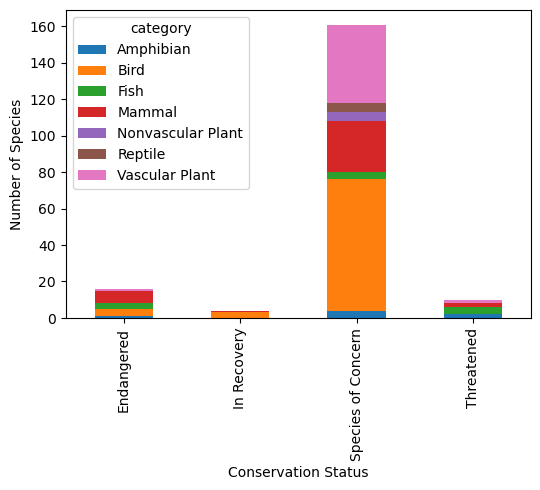

In [15]:
ax = conservationCategory.plot(kind = 'bar',
                               figsize=(6,4),
                               stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species");

#### In conservation

The next question is if certain types of species are more likely to be endangered? This can be answered by creating a new column called `is_protected` and include any species that had a value other than `No Intervention`. 

In [16]:
species['is_protected'] = species['conservation_status'] != 'No Intervention'

Once the new column is created, group by `category` and `is_protected` to show the break down of each species type and protection status. 

Birds, Vascular Plants, and Mammals have a higher absolute number of species protected. 

In [17]:
category_counts = species.groupby(['category', 'is_protected'])['scientific_name'].nunique()\
                        .reset_index()\
                        .pivot(columns='is_protected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']

category_counts.sort_values(by=['protected'], ascending=False).reset_index(drop=True)

,category,not_protected,protected
0,Bird,413,75
1,Vascular Plant,4216,46
2,Mammal,146,30
3,Fish,115,11
4,Amphibian,72,7
5,Nonvascular Plant,328,5
6,Reptile,73,5


Absolute numbers are not always the most useful statistic; therefore rate of protection is calculated. From this, 17.0% of mammals were under protection, as well as 15.4% percent of birds. 

In [18]:
category_counts['percent_protected'] = category_counts['protected'] / \
                                      (category_counts['protected'] + category_counts['not_protected']) * 100

category_counts = category_counts.sort_values(by=['percent_protected'], ascending=False).reset_index(drop=True)
category_counts

,category,not_protected,protected,percent_protected
0,Mammal,146,30,17.045455
1,Bird,413,75,15.368852
2,Amphibian,72,7,8.860759
3,Fish,115,11,8.730159
4,Reptile,73,5,6.410256
5,Nonvascular Plant,328,5,1.501502
6,Vascular Plant,4216,46,1.079305


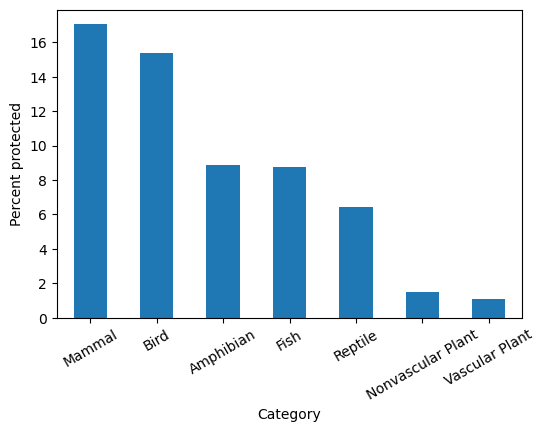

In [19]:
ax = category_counts.plot(kind = 'bar',
                          x = 'category',
                          y = 'percent_protected',
                          legend = False,
                          rot = 30,
                          figsize=(6,4))
ax.set_xlabel("Category")
ax.set_ylabel("Percent protected");

### Statistical Significance

For comparisons between 2 nominal variables, chi-squared tests is used. The following analysis aims to see if different species have statistically significant differences in conservation status rates. A contingency table like the one below will need to be created:

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Bird|?|?|

P-value 0.69 > 0.05 which suggests there doesn't seem to be any significant relationship between mammals and birds.

In [20]:
cat1 = 'Mammal'
cat2 = 'Bird'

X = category_counts.loc[category_counts['category']==cat1, ['not_protected', 'protected']].values
y = category_counts.loc[category_counts['category']==cat2, ['not_protected', 'protected']].values

In [21]:
from scipy.stats import chi2_contingency

contingency1 = [X,y]
chi2_contingency(contingency1)

Chi2ContingencyResult(statistic=0.16170148316545574, pvalue=0.6875948096661336, dof=1, expected_freq=array([[[148.1686747,  27.8313253]],

       [[410.8313253,  77.1686747]]]))


The next pair, is going to test the difference between `Reptile` and `Mammal`.

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Reptile|?|?|

P-value 0.039 < 0.05 suggesting the difference between reptile and mammal is statistically significant. Mammals are shown to have a statistically significant higher rate of needed protection compared with Reptiles. 

In [22]:
cat1 = 'Mammal'
cat2 = 'Reptile'

contingency2 = [X,y]
chi2_contingency(contingency2)

Chi2ContingencyResult(statistic=0.16170148316545574, pvalue=0.6875948096661336, dof=1, expected_freq=array([[[148.1686747,  27.8313253]],

       [[410.8313253,  77.1686747]]]))

### Multiple comparisons

The tests above only consider 2 combinations of conservation status and `category`. To determine which `category` has significantly higher rates of protection compared to the rest, more tests will have to be run.

In [23]:
category_counts

,category,not_protected,protected,percent_protected
0,Mammal,146,30,17.045455
1,Bird,413,75,15.368852
2,Amphibian,72,7,8.860759
3,Fish,115,11,8.730159
4,Reptile,73,5,6.410256
5,Nonvascular Plant,328,5,1.501502
6,Vascular Plant,4216,46,1.079305


In [24]:
category_protected = [list(category_counts['protected']),list(category_counts['not_protected'])]
contingency_category_protected = np.array(category_protected).T # transpose array to a suitable format for chi2_contingency 
chi2_contingency(contingency_category_protected)

Chi2ContingencyResult(statistic=426.52931383200115, pvalue=5.5108280473137505e-89, dof=6, expected_freq=array([[5.68459040e+00, 1.70315410e+02],
       [1.57618188e+01, 4.72238181e+02],
       [2.55160592e+00, 7.64483941e+01],
       [4.06964995e+00, 1.21930350e+02],
       [2.51930711e+00, 7.54806929e+01],
       [1.07555034e+01, 3.22244497e+02],
       [1.37657524e+02, 4.12434248e+03]]))

The overall 7x2 table yields a chi-square of 426.53 with 6 degrees of freedom and a P-value of 5.51, which is not significant. This suggests there are no significant differences between the 7 `category`, which is odd given the (Mammal, Reptile) combination yielded statistically significant differences.  

When the chi-square test of a table larger than 2×2 is significant (and sometimes when it is not, as above), it is desirable to investigate the data further.

### Post-hoc Tests

There are 2 approaches to multiple comparisons:
- All pairwise comparisons (2x2 between all 7 `category`, $_{7}C_{2}$ = 21 pairwise comparisons)
- One vs All comparisons (7 pairwise comparisons)

When more statistical tests are run, the number of false positives increases. Thus, it is important to decide beforehand which approach to take.

*Definitions:*
- *Familywise Error Rate (FWER) is the probability of making any Type I errors (false positives) at all.*
- *False Discovery Rate (FDR) is the expected proportion of false positives out of all rejections (false positives + true positives).*

For the following analyses, all pairwise comparisons will be made, and 2 different methods of multicomparison corrections will be applied:
1) Familywise Error Rate (FWER) using Holm-Bonferroni method
2) False Discovery Rate (FDR) using Benjamini-Hochberg method

### Multicomparison correction 1: Familywise Error Rate (FWER) using Holm-Bonferroni method

The Bonferroni method reduces the significance level, $a$, by dividing $a$ by the number of comparisons made, $m$ (in this case $m = 21$). Each test is then compared against this new $\frac{a}{m} = \frac{0.05}{21} = 0.00238$. If $p_{i} \leq 0.00238$, reject $H_{i}$.

The Bonferroni method is most commonly used for FWER correction. However, the Holm–Bonferroni method is "uniformly" more powerful than the classic Bonferroni correction, meaning that it is always at least as powerful.

The Holm-Bonferroni method includes additional step-wise comparisons such that:
1) Sort lowest-to-highest all P-values ($P_{1} \dots P_{m}$) and corresponding null hypotheses ($H_{1} \dots H_{m}$), and determine significance level, $a$ ($a = 0.05$ is used here).
2) If $P1 < a/m$, reject $H_{1}$ and proceed, otherwise EXIT.
3) If $P2 < a / (m-1)$, reject $H_{2}$ and proceed, otherwise EXIT.
4) Continue for all values of $P$ test $P_{k} < \frac{a}{m - 1 +k}$ and reject $H_{k}$ where True, otherwise EXIT.

More information on Bonferroni method can be found [here](https://en.wikipedia.org/wiki/Bonferroni_correction), and Holm-Bonferroni method [here](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method).

In [25]:
# Acknowledgement: Code adapted from Moran Neuhofmo, 2018. https://github.com/neuhofmo/chisq_test_wrapper/tree/master

from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

# Original code prints number of asterisks corresponding to p-value; not used in this project. 

# def get_asterisks_for_pval(p_val):
#     """Receives the p-value and returns asterisks string."""
#     if p_val > 0.05:
#         p_text = "ns"  # above threshold => not significant
#     elif p_val < 1e-4:  
#         p_text = '****'
#     elif p_val < 1e-3:
#         p_text = '***'
#     elif p_val < 1e-2:
#         p_text = '**'
#     else:
#         p_text = '*'
    
#     return p_text

def chisq_and_posthoc_corrected(df, correction_method):
    """
    Receives a dataframe and performs chi2 test and then post-hoc correction.
    Outputs: Pandas DataFrame
         Combinations
         Initial p-values and reject condition
         Post-Hoc corrected p-values and reject condition.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame to apply chi2 test and posthoc correction. Index must be reset to fit function.
    method: str
        Method to apply for posthoc correction. Uses statsmodels.sandbox.stats.multicomp.multipletests
        `bonferroni` : one-step correction
        `sidak` : one-step correction
        `holm-sidak` : step down method using Sidak adjustments
        `holm` : step-down method using Bonferroni adjustments
        `simes-hochberg` : step-up method  (independent)
        `hommel` : closed method based on Simes tests (non-negative)
        `fdr_bh` : Benjamini/Hochberg  (non-negative)
        `fdr_by` : Benjamini/Yekutieli (negative)
        `fdr_tsbh` : two stage fdr correction (non-negative)
        `fdr_tsbky` : two stage fdr correction (non-negative)
    """
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df, correction=False)
    print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")
    
    # post-hoc
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
    initial_reject = []
    print("Significance results:")
    for combination in all_combinations:
        new_df = df[(df.index == combination[0]) | (df.index == combination[1])]
        chi2, p, dof, ex = chi2_contingency(new_df, correction=False)
        p_vals.append(p)
        initial_reject.append(True if p < 0.05 else False)
        # print(f"For {comb}: {p}")  # uncorrected

    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method=correction_method)[:2] # multipletests has 4 outputs; we only need first 2
    
    output = pd.DataFrame(zip(all_combinations, p_vals, initial_reject, corrected_p_vals, reject_list),
                          columns=['combinations', 'initial_p_value','initial_reject', 'corrected_p_value', 'corrected_reject'])
    
#     for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
#         print(f"{comb}: p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(p_val)}) reject: {reject}")
        
    return output

The function above takes in the DataFrame in the following format (resetting of index might be necessary):

|X|y1|y2|
|-|-|-|
|X1|?|?|
|X2|?|?|
|...|?|?|
|Xn|?|?|

In [26]:
# format table for function compatibility; set index to X
table = category_counts.drop(['percent_protected'], axis=1).set_index(category_counts.columns[0])
table

,not_protected,protected
category,,
Mammal,146,30
Bird,413,75
Amphibian,72,7
Fish,115,11
Reptile,73,5
Nonvascular Plant,328,5
Vascular Plant,4216,46


In [27]:
fwer_corrected = chisq_and_posthoc_corrected(table, 'holm')
fwer_corrected

Chi2 result of the contingency table: 426.5293138320011, p-value: 5.5108280473137505e-89
Significance results:


,combinations,initial_p_value,initial_reject,corrected_p_value,corrected_reject
0,"(Mammal, Bird)",6.012440e-01,False,1.000000e+00,False
1,"(Mammal, Amphibian)",8.616488e-02,False,6.031541e-01,False
2,"(Mammal, Fish)",3.750477e-02,True,3.495897e-01,False
3,"(Mammal, Reptile)",2.330790e-02,True,2.563869e-01,False
4,"(Mammal, Nonvascular Plant)",4.357893e-11,True,7.844207e-10,True
5,"(Mammal, Vascular Plant)",1.287408e-57,True,2.574816e-56,True
6,"(Bird, Amphibian)",1.270655e-01,False,7.623931e-01,False
7,"(Bird, Fish)",5.558982e-02,False,4.447185e-01,False
8,"(Bird, Reptile)",3.495897e-02,True,3.495897e-01,False
9,"(Bird, Nonvascular Plant)",4.744374e-11,True,8.065436e-10,True


In [28]:
fwer_corrected[fwer_corrected['initial_reject'] != fwer_corrected['corrected_reject']]

,combinations,initial_p_value,initial_reject,corrected_p_value,corrected_reject
2,"(Mammal, Fish)",0.037505,True,0.349590,False
3,"(Mammal, Reptile)",0.023308,True,0.256387,False
8,"(Bird, Reptile)",0.034959,True,0.349590,False
18,"(Reptile, Nonvascular Plant)",0.011318,True,0.135812,False


P-values obtained from chi-square comparisons for each pair have been adjusted for Familywise Error Rate (FWER). Combinations with "True" in the `_reject` columns differ significantly.

Before correcting for FWER, there are 4 combinations under the `initial_reject` column that were signficantly different in protection rates - `(Mammal, Fish)`, `(Mammal, Reptile)`, `(Bird, Reptile)`, `(Reptile, Nonvascular Plant)`.

However after FWER correction they no longer significantly differ, that is the reject condition is no longer `True`, but `False` under the `corrected_reject` column.

### Multicomparison correction 2: False Discovery Rate (FDR) using Benjamini-Hochberg method

As stated above, the FDR is the expected ratio of the number of false positive classifications (false discoveries) to the total number of positive classifications (rejections of the null), that is:

$$ FDR = \frac{False Positives}{False Positives + True Positives} $$

More information on the Benjamini-Hochberg method to control FDR can be found [here](https://en.wikipedia.org/wiki/False_discovery_rate).

In [29]:
fdr_corrected = chisq_and_posthoc_corrected(table, 'fdr_bh')
fdr_corrected

Chi2 result of the contingency table: 426.5293138320011, p-value: 5.5108280473137505e-89
Significance results:


,combinations,initial_p_value,initial_reject,corrected_p_value,corrected_reject
0,"(Mammal, Bird)",6.012440e-01,False,6.313062e-01,False
1,"(Mammal, Amphibian)",8.616488e-02,False,1.206308e-01,False
2,"(Mammal, Fish)",3.750477e-02,True,6.058463e-02,False
3,"(Mammal, Reptile)",2.330790e-02,True,4.449691e-02,True
4,"(Mammal, Nonvascular Plant)",4.357893e-11,True,1.992637e-10,True
5,"(Mammal, Vascular Plant)",1.287408e-57,True,1.351778e-56,True
6,"(Bird, Amphibian)",1.270655e-01,False,1.667735e-01,False
7,"(Bird, Fish)",5.558982e-02,False,8.338473e-02,False
8,"(Bird, Reptile)",3.495897e-02,True,6.058463e-02,False
9,"(Bird, Nonvascular Plant)",4.744374e-11,True,1.992637e-10,True


In [30]:
fdr_corrected[fdr_corrected['initial_reject'] != fdr_corrected['corrected_reject']]

,combinations,initial_p_value,initial_reject,corrected_p_value,corrected_reject
2,"(Mammal, Fish)",0.037505,True,0.060585,False
8,"(Bird, Reptile)",0.034959,True,0.060585,False


Before correcting for FDR, there were 2 combinations under the `initial_reject` column that were signficantly different in protection rates - `(Mammal, Fish)` and `(Bird, Reptile)`.

### Which multicomparison correction to use?

**When doing multiple comparisons [(from Wikipedia)](https://en.wikipedia.org/wiki/Multiple_comparisons_problem)...**
- For large-scale testing problems where the goal is to provide definitive results, the family-wise error rate (FWER) remains the most accepted parameter for ascribing significance levels to statistical tests.
- Alternatively, if a study is viewed as exploratory, or if significant results can be easily re-tested in an independent study, control of the false discovery rate (FDR) is often preferred.
    - Additionally, if the cost of additional experiments is low and the cost of a false negative (missing a potentially important discovery) is high, a fairly high false discovery rate should be used, like 0.10 or 0.20, so that anything important is not missed.
    - Sometimes people use a false discovery rate of 0.05, probably because of confusion about the difference between false discovery rate and probability of a false positive when the null is true; a false discovery rate of 0.05 is probably too low for many experiments. [(McDonald, J.H. 2014)](https://www.biostathandbook.com/multiplecomparisons.html). 

FDR corrections allow for more Type I errors (i.e. False Positives), that is more pairwise comparisons yielding statistically significant results that could be False Positives, compared to FWER corrections.

From the differences in correction tables above, FDR correction adjusted p-values that yielded significant differences for `(Mammal, Reptile)` and `(Reptile, Nonvascular Plant)` comparisons, where FWER correction did not. These two pairs could be False Positives.

Since this dataset can be considered exploratory, there is no need to be overly conservative with discovering differences. Hence, for this project FDR corrected values will be accepted, resulting in 11 out of 21 pairwise comparisons yielding significantly different results.

#### Species in Parks

The next set of analysis will come from data from the conservationists as they have been recording sightings of different species at several national parks for the past 7 days.

The first step is to look at the the common names from `species` to get an idea of the most prevalent animals in the dataset. The data will be need to be split up into individual names. 

In [31]:
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species[species.category == "Mammal"]['common_names']\
    .apply(remove_punctuations)\
    .str.split().tolist()

common_Names[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

The next step is to clean up duplicate words in each row since they should no be counted more than once per species.

In [32]:
cleanRows = []

for item in common_Names:
    item = list(dict.fromkeys(item))
    cleanRows.append(item)
    
cleanRows[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

Next the words need to be collapsed into one list for easier use.

In [33]:
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in cleanRows))
res[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

Now the data is ready to be able to count the number of occurrences of each word. From this analysis, it seems that `Bat` occurred 23 times while `Shrew` came up 18 times.

In [34]:
words_counted = []

for i in res:
    x = res.count(i)
    words_counted.append((i,x))

pd.DataFrame(set(words_counted), columns =['Word', 'Count']).sort_values("Count", ascending = False).head(10)

,Word,Count
79,Bat,23
197,Shrew,18
168,Myotis,17
32,Mouse,16
105,Chipmunk,13
136,Squirrel,12
129,American,12
51,Eastern,11
162,Vole,11
137,Western,10


In the data, there are several different scientific names for different types of bats.  The next task is to figure out which rows of `species` are referring to bats. A new column made up of boolean values will be created to check if `is_bat` is `True`.

In [35]:
species['is_bat'] = species['common_names'].str.contains(r"\bBat\b", regex = True)

species.head(10)

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No Intervention,False,False
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",No Intervention,False,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True,False
8,Mammal,Canis lupus,Gray Wolf,Endangered,True,False
9,Mammal,Canis rufus,Red Wolf,Endangered,True,False


Here is a subset of the data where `is_bat` is true, returning see the rows that matched. There seems to be a lot of species of bats and a mix of protected vs. non-protected species. 

In [36]:
species[species['is_bat']]

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
28,Mammal,Corynorhinus rafinesquii,Rafinesque's Big-Eared Bat,No Intervention,False,True
29,Mammal,Eptesicus fuscus,Big Brown Bat,Species of Concern,True,True
30,Mammal,Lasionycteris noctivagans,Silver-Haired Bat,Species of Concern,True,True
31,Mammal,Lasiurus borealis,"Eastern Red Bat, Red Bat",No Intervention,False,True
32,Mammal,Lasiurus cinereus,Hoary Bat,No Intervention,False,True
36,Mammal,Myotis leibii,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
37,Mammal,Myotis lucifugus,"Little Brown Bat, Little Brown Myotis",Species of Concern,True,True
38,Mammal,Myotis septentrionalis,"Northern Long-Eared Bat, Northern Myotis",Threatened,True,True
39,Mammal,Myotis sodalis,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
40,Mammal,Nycticeius humeralis,Evening Bat,No Intervention,False,True


Next the results of the bat species will be merged with `observations` to create a `DataFrame` with observations of bats across the four national parks.  

In [37]:
bat_observations = observations.merge(species[species['is_bat']])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,False,True
...,...,...,...,...,...,...,...,...
139,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
140,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
141,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
142,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


Let's see how many total bat observations(across all species) were made at each national park.  

The total number of bats observed in each park over the past 7 days are in the table below. Yellowstone National Park seems to have the largest with 8,362 observations and the Great Smoky Mountains National Park having the lowest with 2,411. 

In [38]:
bat_observations.groupby('park_name')['observations'].sum().reset_index()\
.sort_values(by='observations',ascending=False).reset_index(drop=True)

,park_name,observations
0,Yellowstone National Park,8362
1,Yosemite National Park,4786
2,Bryce National Park,3433
3,Great Smoky Mountains National Park,2411


Now let's see each park broken down by protected bats vs. non-protected bat sightings. It seems that every park except for the Great Smoky Mountains National Park has more sightings of protected bats than not. This could be considered a great sign for bats.

In [39]:
obs_by_park = bat_observations.groupby(['park_name', 'is_protected'])['observations'].sum().reset_index()
obs_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1596
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1299
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4044
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2345
7,Yosemite National Park,True,2441


Below is a plot from the output of the last data manipulation. From this chart one can see that Yellowstone and Bryce National Parks seem to be doing a great job with their bat populations since there are more sightings of protected bats compared to non-protected species. The Great Smoky Mountains National Park might need to beef up there efforts in conservation as they have seen more non-protected species.

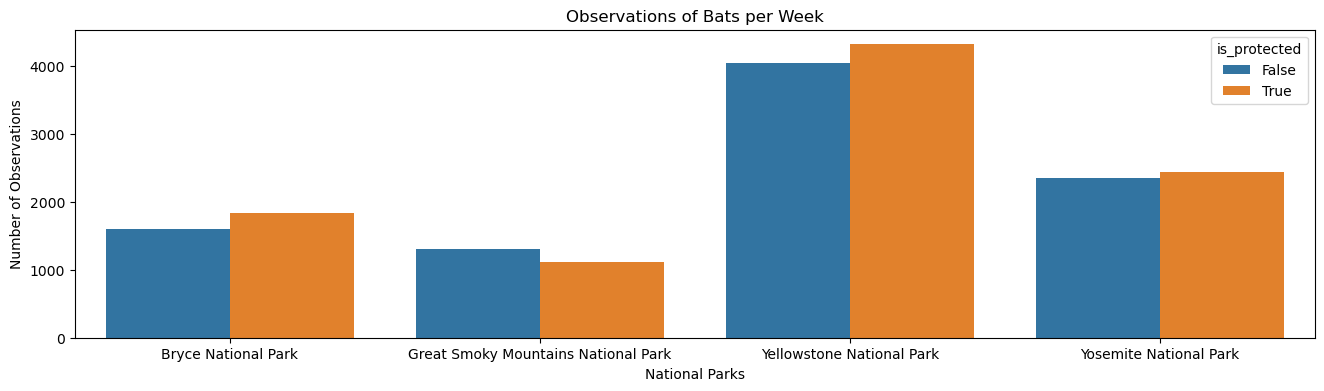

In [41]:
plt.figure(figsize=(16, 4))
sns.barplot(data = obs_by_park,
            x = 'park_name',
            y = 'observations',
            hue = 'is_protected')
plt.xlabel('National Parks')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats per Week')
plt.show()

## Conclusions

The project was able to make several data visualizations and inferences about the various species in four of the National Parks that comprised this dataset.

This project was also able to answer some of the questions first posed in the beginning:

- What is the distribution of conservation status for species?
    - The vast majority of species were not part of conservation.(5,633 vs 191)
- Are certain types of species more likely to be endangered?
    - Mammals and Birds had the highest percentage of being in protection.
- Are the differences between species and their conservation status significant?
    - When comparing between all species, 11 pairwise comparisons out of 21 possible pairs were significantly different, after False Discovery Rate (FDR) correction.
- Which animal is most prevalent and what is their distribution amongst parks?
    - The study found that bats occurred the most number of times and they were most likely to be found in Yellowstone National Park.


## Further Research 

This dataset only included observations from the last 7 days which prohibits analyze changes over time. It would be curious to see how the conservation status for various species changes over time. Another piece that is missing is the Area of each park, it can be assumed that Yellowstone National Park might be much larger than the other parks which would mean that it would exhibit more observations and greater biodiversity. Lastly, if precise locations were recorded, the spatial distribution of the species could also be observed and test if these observations are spatially clustered. 